In [1]:
import pandas as pd
import numpy as np
import pickle

def save_obj(obj, name):
    with open(obj, 'wb') as f:
        pickle.dump(name, f)


def load_obj(obj):
    with open(obj, 'rb') as f:
        return pickle.load(f)

df = pd.read_csv('data/creatives.csv')
df.head()

,dt,application_dm_id,application_name,os_name,country,media_source,creative_name,impressions,clicks,installs
0,2022-01-10,1189193,Application Two,ios,US,unityads_int,42.0,13955,3852,57
1,2022-01-10,1189193,Application Two,ios,DK,unityads_int,5.0,237,10,2
2,2022-01-10,1189193,Application Two,ios,CA,applovin_int,2.0,13154,4664,231
3,2022-01-10,1308183,Application One,android,SA,unityads_int,10.0,11606,3931,563
4,2022-01-10,1189194,Application Two,android,BG,applovin_int,2.0,517,144,7


In [2]:
df = df.dropna()
df = df.drop(columns = 'dt')
df = df.drop(columns = 'application_dm_id')

df.shape

(270594, 8)

In [3]:
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer

numerical_columns_selector = make_column_selector(dtype_exclude=object)
categorical_columns_selector = make_column_selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

print('Numerical columns: ', numerical_columns)
print('\nCategorical columns: ', categorical_columns)

Numerical columns:  ['creative_name', 'impressions', 'clicks', 'installs']

Categorical columns:  ['application_name', 'os_name', 'country', 'media_source']


In [4]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

categorical_preprocessor = OrdinalEncoder()
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('ordinal_encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

n_df = preprocessor.fit_transform(df)

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(n_df)

C:\Users\alexa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\alexa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [6]:
save_obj('tsne.pickle', tsne_transformed)

In [7]:
tsne_transformed.shape

(270594, 2)

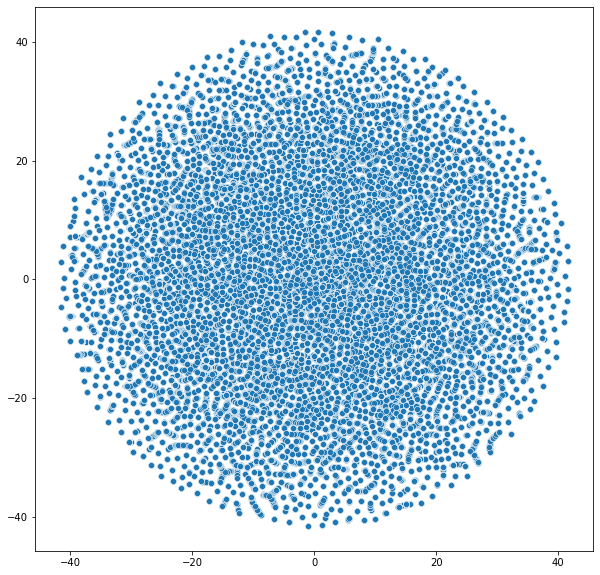

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_transformed[:, 0], 
    y=tsne_transformed[:, 1], 
    palette="CMRmap",
    legend='full'
);

In [9]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(tsne_transformed)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

Estimated number of clusters: 2523
Estimated number of noise points: 268


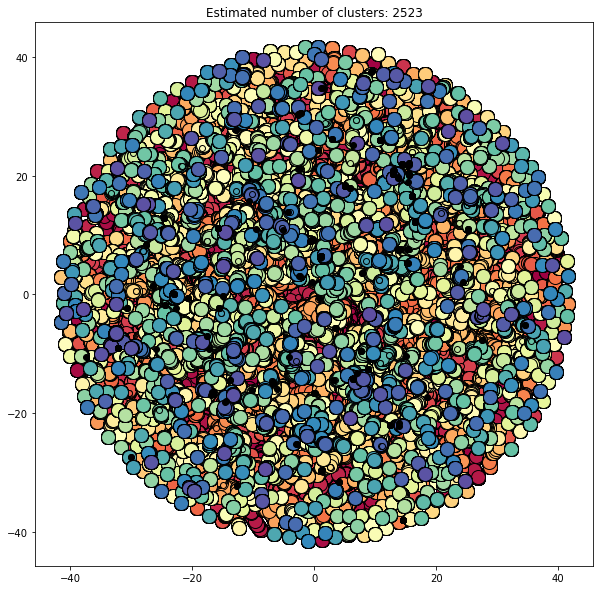

In [10]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


# Black removed and is used for noise instead.
plt.figure(figsize=(10, 10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = tsne_transformed[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = tsne_transformed[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

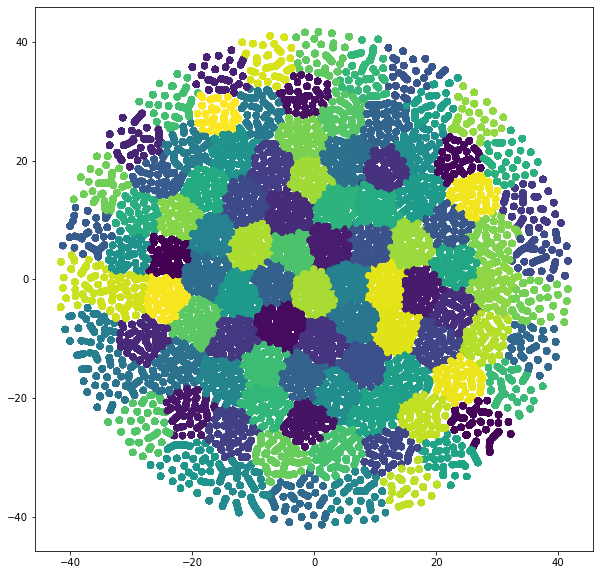

In [11]:
from sklearn.cluster import KMeans 

kmeans = KMeans(n_clusters=100, random_state=42)
y_pred = kmeans.fit_predict(tsne_transformed)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:,0], tsne_transformed[:,1], c=y_pred)
plt.show()